# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
import scipy as sp

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from tsfresh.feature_selection.selection import select_features

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features, select_features,extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute,make_forecasting_frame
from tsfresh.feature_extraction import settings, EfficientFCParameters,MinimalFCParameters 

from tqdm import tqdm

In [2]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting import plot_autocorrelation

In [3]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
    'text.color': 'black',
    'axes.labelcolor': 'black',
})


In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing the reduced dataset

In [1]:
df = pd.read_csv('processed_datasets/reduced_dataset.csv.zip')
df

NameError: name 'pd' is not defined

In [8]:
#import datetime
#start = datetime.datetime.now()
#end = start + datetime.timedelta(hours=1)
#time = pd.date_range(freq='1d', start=0, periods=len(df)) 

#df.index=time
#df

In [9]:
eigenvector = 0
series = pd.DataFrame(df[df.columns[eigenvector]])  # Grabbing one of the 92 eigenvectors
series

0
0     5.472871
1     5.456736
2     5.456897
3     5.472629
4     5.501610
...        ...
5995 -4.149586
5996 -3.869611
5997 -3.593313
5998 -3.312633
5999 -3.022673

[6000 rows x 1 columns]

## Hurst coefficient

The Hurst exponent is used as a measure of **long-term memory** of a time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

Long-range dependence (LRD), also called long memory or long-range persistence, is a phenomenon that may arise in the analysis of spatial or time series data. It relates to the rate of decay of statistical dependence of two points with increasing time interval or spatial distance between the points (lags). A phenomenon is usually considered to have **long-range dependence** if the dependence decays more slowly than an exponential decay, typically a power-like decay.

- Short-range dependence, 
The coupling between values at different times decreases rapidly as the time difference increases. Either the autocovariance drops to zero after a certain time-lag, or it eventually has an exponential decay. 

- Long-range dependence, 
There is much stronger coupling. The decay of the autocovariance function is power-like and so is slower than exponential.

The Hurst coefficient H is a number between 0 and 1

- H = 0.5
This is indicative of a Brownian series (white noise). There is no correlation between current observations and future observations. No short- or long-term cyclical dependencies are expected. In trading, this means that technical analysis is of no much help since the current values are almost unaffected by the previous ones.

- H > 0.5
This is indicative of a Persistent time-series. If the Hurst exponent is above 0.5, the series shows a trending behaviour. Past moves are similar to current moves. This means all the following results strongly depend on the previous ones within a certain time period, thererfore, has long term memory. 

- H < 0.5
This is indicative of an Anti-Persistent time-series. In, the short term, values will tend to go against their existing trends  (i.e., values will tend to revert to a mean). The system changes faster than a random one, i.e. it is prone to small but frequent changes. 

E(R/S) = c * T^H

In [10]:
!pip install hurst

In [11]:
from hurst import compute_Hc, random_walk

H_list = []
min_window=10
max_window=6000

def hurst_plot(eigenvector,min_window,max_window):
    """
    E(R/S) = c * T^H
    H, c and data
        where H and c — parameters or Hurst equation
        and data is a list of 2 lists: time intervals and R/S-values for correspoding time interval
        for further plotting log(data[0]) on X and log(data[1]) on Y
    """
    
    series = pd.DataFrame(df[df.columns[eigenvector]])  # Grabbing one of the 92 eigenvectors
    H, c, data = compute_Hc(series,min_window=min_window,max_window=max_window)
    #print("Hurst exponent = {:.4f}".format(H))
    H_list.append(H)
    return

for i in tqdm(np.arange(0,93,1)):
    hurst_plot(i,min_window,max_window=max_window)

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:15<00:00,  6.18it/s]


Text(0.5, 0, 'Eigenvector number')

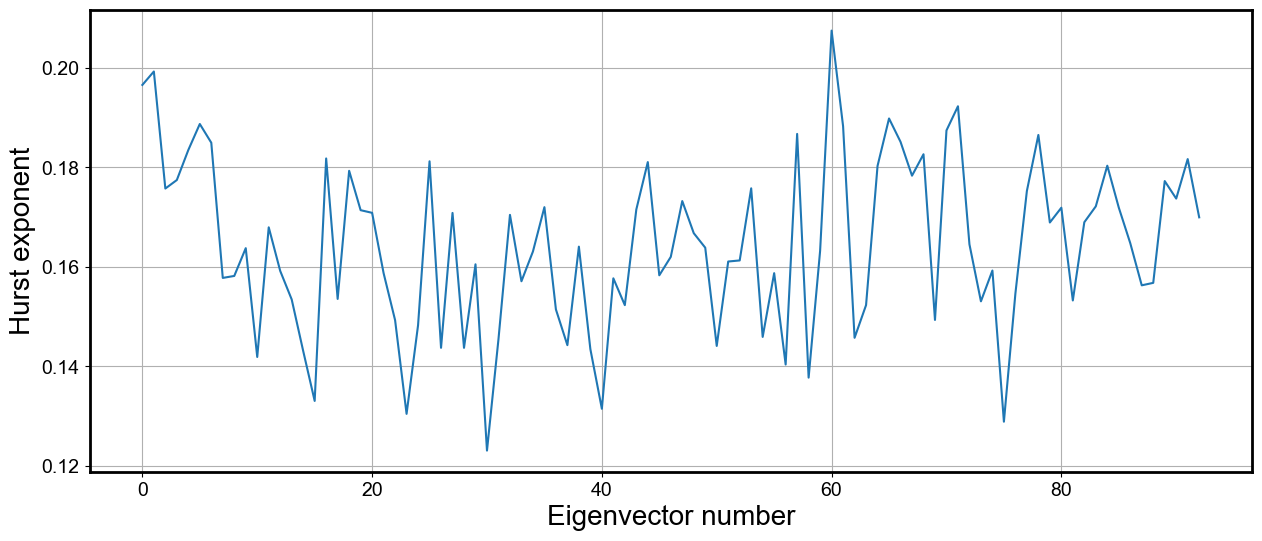

In [12]:
plt.plot(H_list)
plt.ylabel('Hurst exponent')
plt.xlabel('Eigenvector number')

Since the Hurst coefficient is much lower than 0.5 for all eigenvectors, we are dealing with a anti-persistent time series. can expect the to fluctuate rapidly around its mean.

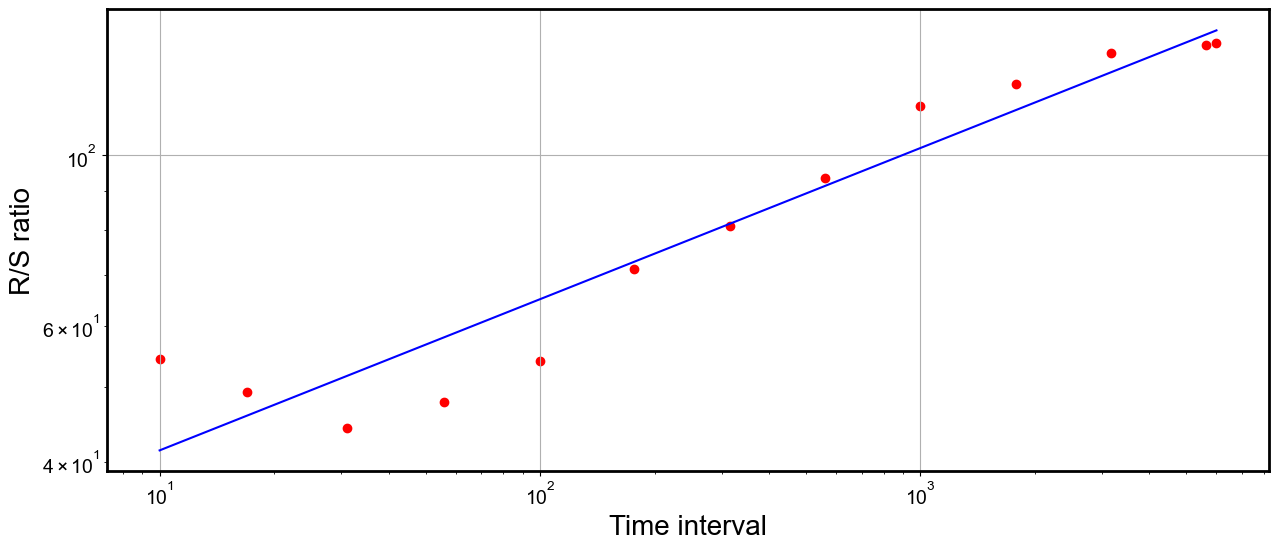

In [13]:
H, c, val = compute_Hc(series,min_window=min_window,max_window=max_window)

axes = plt.subplots()[1]
axes.plot(val[0], c*val[0]**H, color="blue")
axes.scatter(val[0], val[1], color="red")
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Time interval')
axes.set_ylabel('R/S ratio')
axes.grid(True)
plt.show()

# Visualizing time series

In [14]:
from utils.plotting import plot_samples, plot_autocorrelation, dual_heat_map

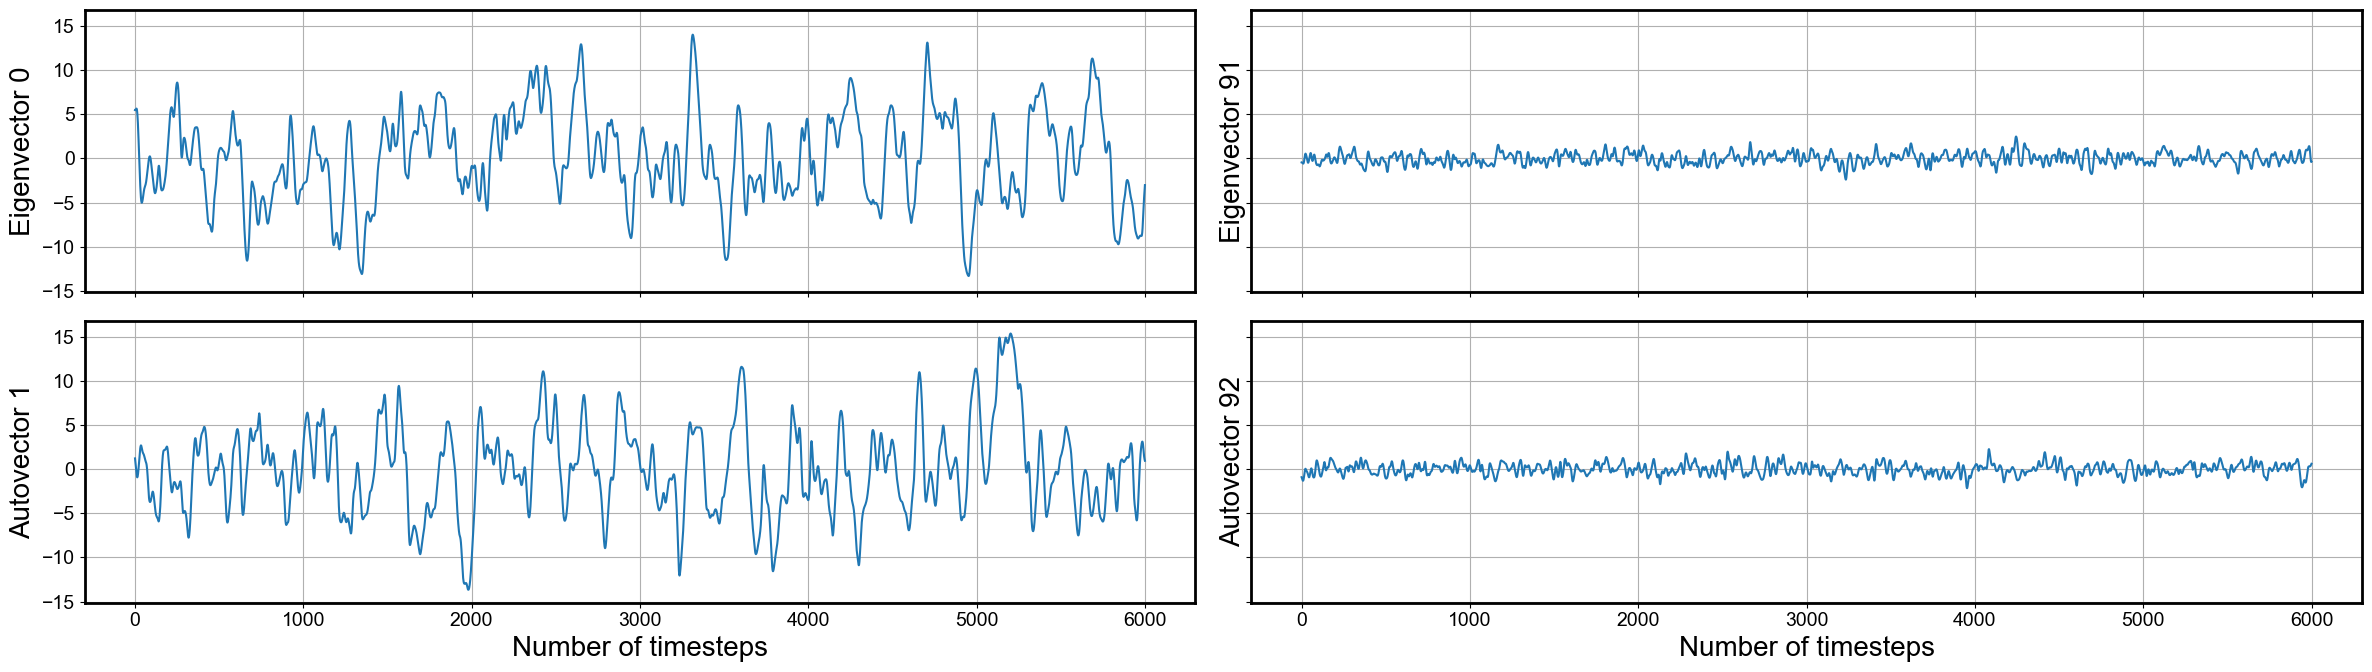

In [15]:
plot_samples(df)

# Visualizing lag features

For random data, autocorrelations should be near zero for all lags (white noise). Non-random data have at least one significant lag. When the data are not random, it’s a good indication that you need to use a time series analysis or incorporate lags into a regression analysis to model the data appropriately.

Looking again into stationarity, our signal must:

- Not have a trend (mean=0);
- Have constant variance;
- Have a constant autocorrelation pattern (below the confidence interval);
- Have no seasonal pattern.

The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series. For a non-stationary time series, the ACF drops slowly. There is also no seasonal components since there are no repetitive peaks in defined multiples for stationary time series.

The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke.

Let us now take a closer look at the partial autocorrelation (PACF). Instead of finding correlations of present values with lags like ACF, PACF finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag. So if through the PACF function we discover that there is hidden information in the residual that can be modeled by the next lag, we might get a good correlation, and we will keep that next lag as a feature while modeling.

As mentioned before, an autoregression is a model based on the assumption that present values of a time series can be obtained using previous values of the same time series: the present value is a weighted average of its past values. In order to avoid multicollinear features for time series models, it is necessary to find optimum features or order of the autoregression process using the PACF plot, as it removes variations explained by earlier lags, so we get only the relevant features.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


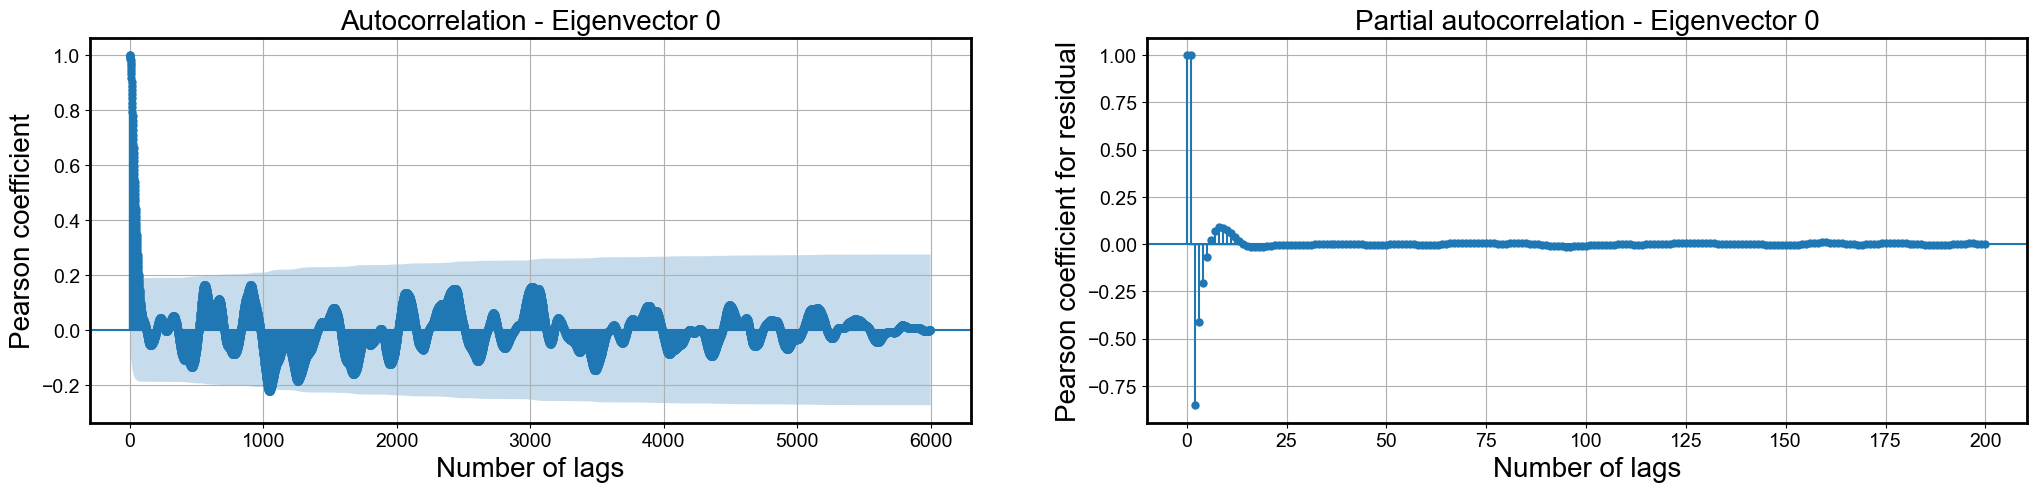

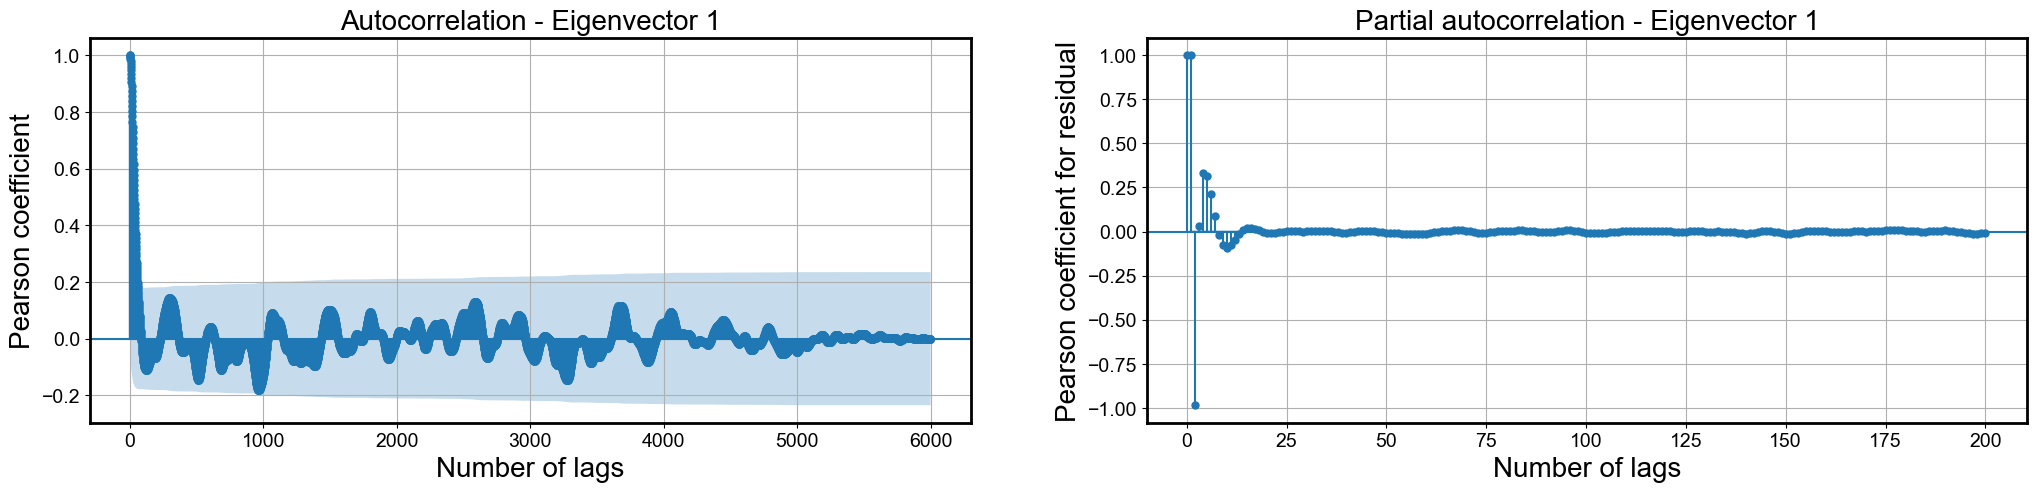

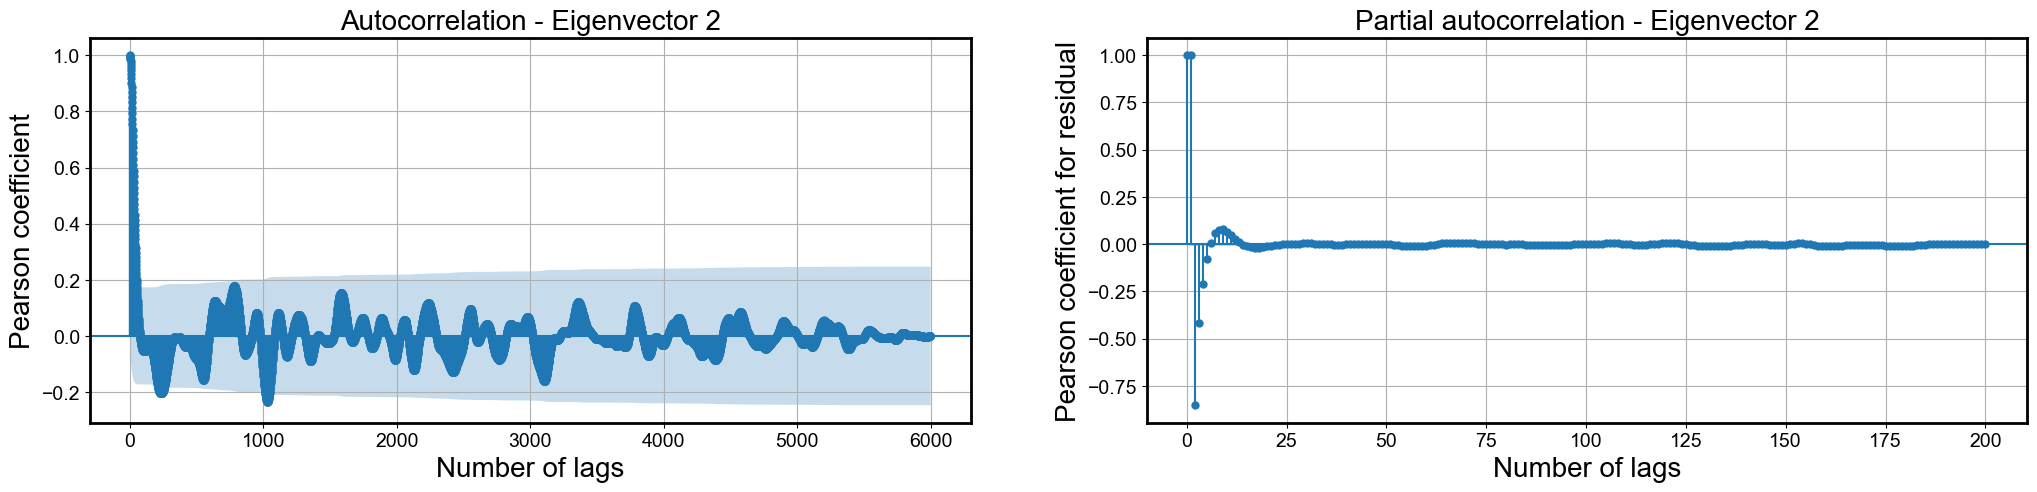

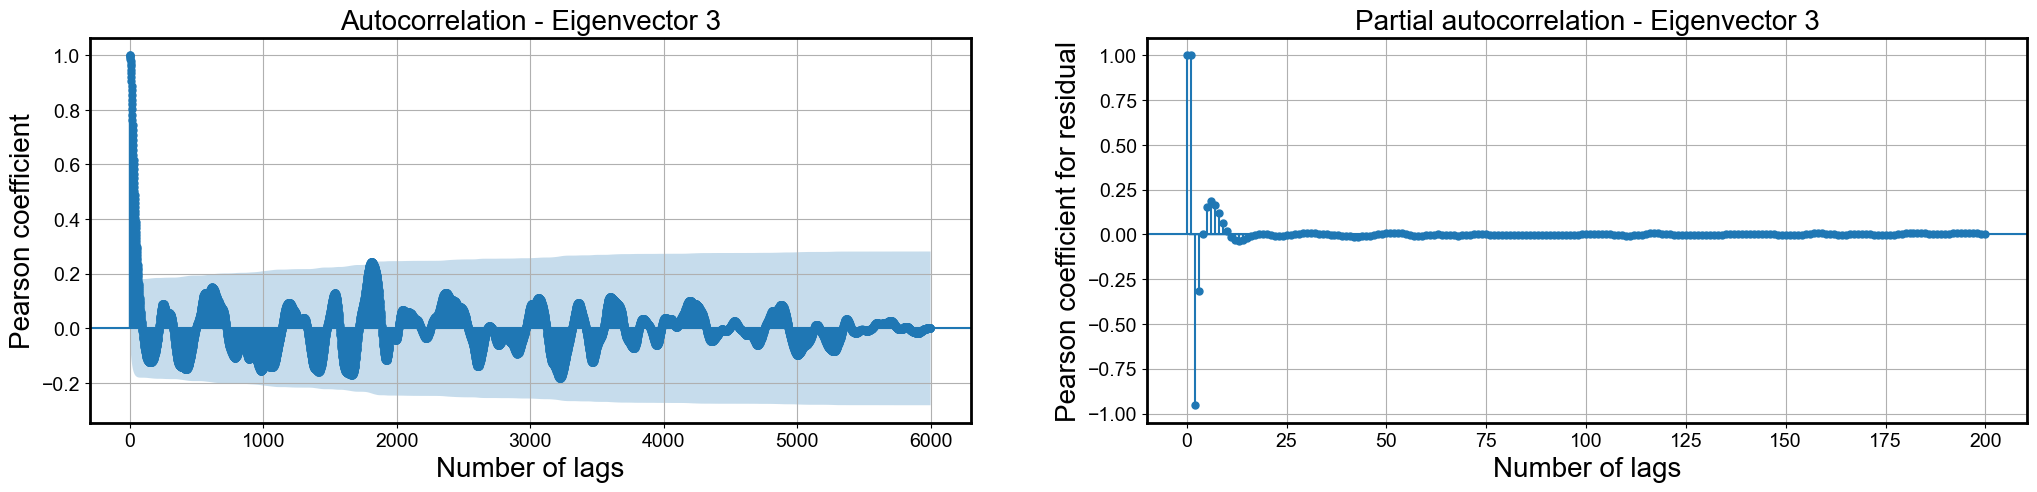

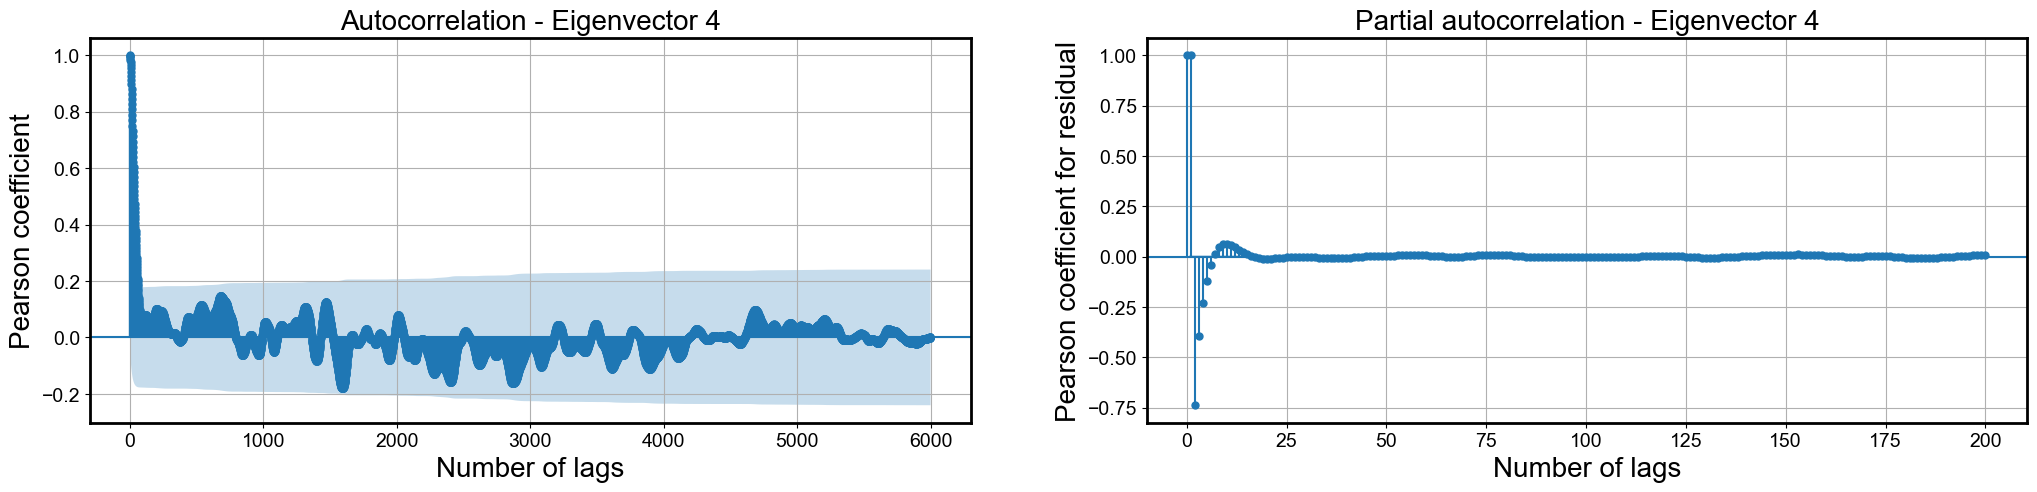

In [16]:
# First eigenvectors
for i in tqdm(range(5)):
    plot_autocorrelation(df,i)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


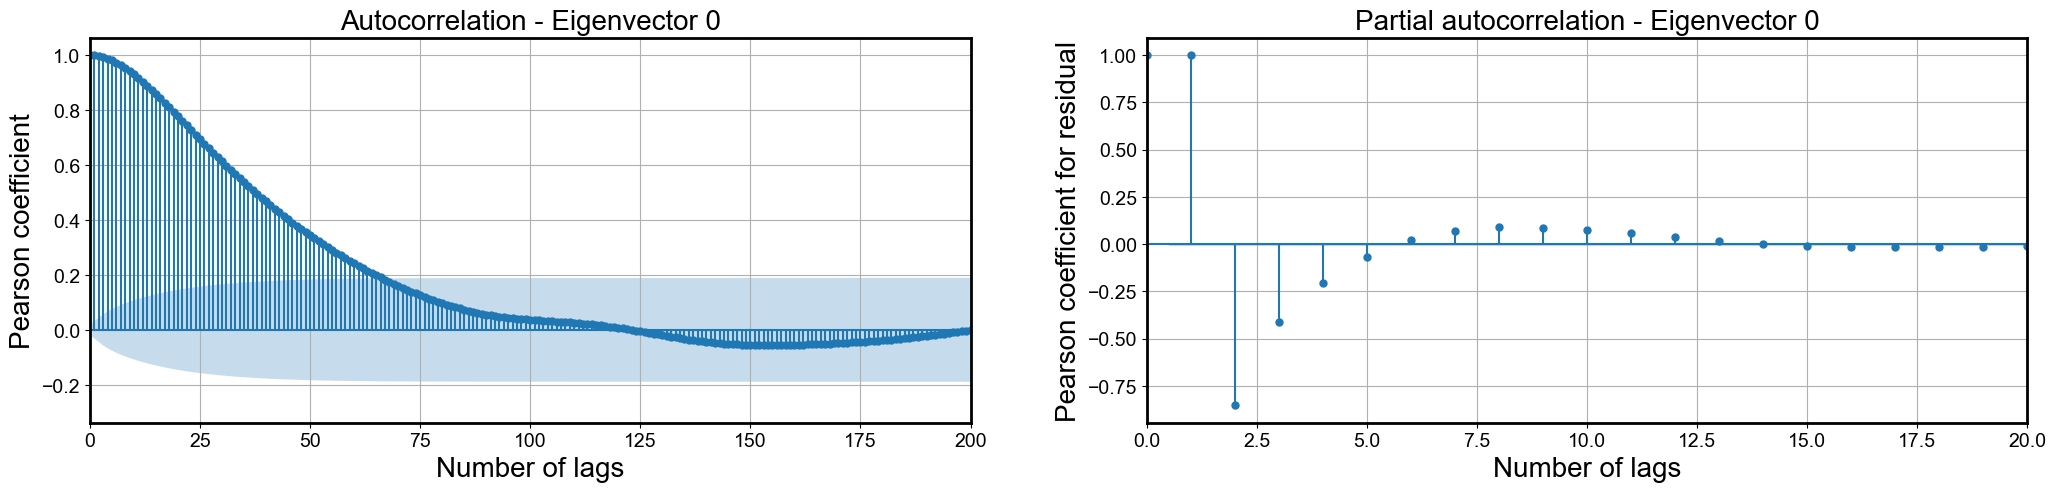

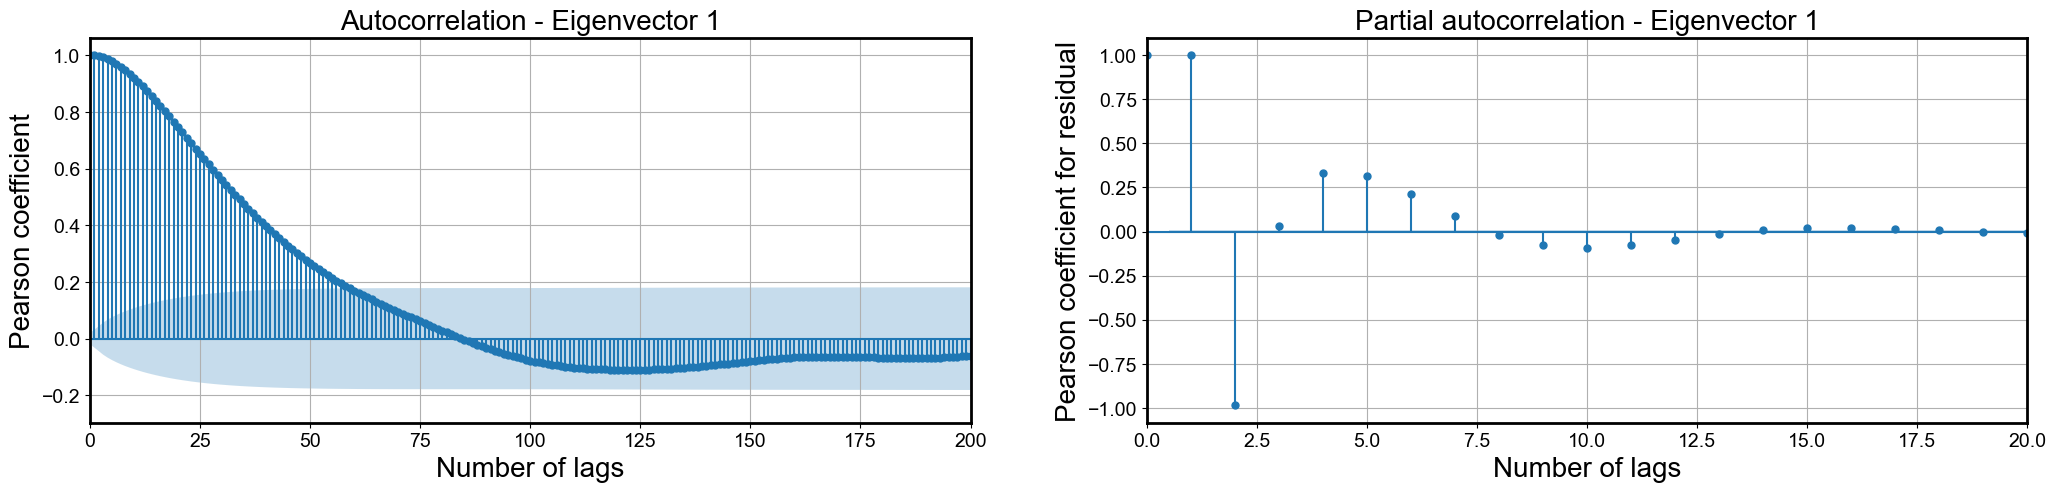

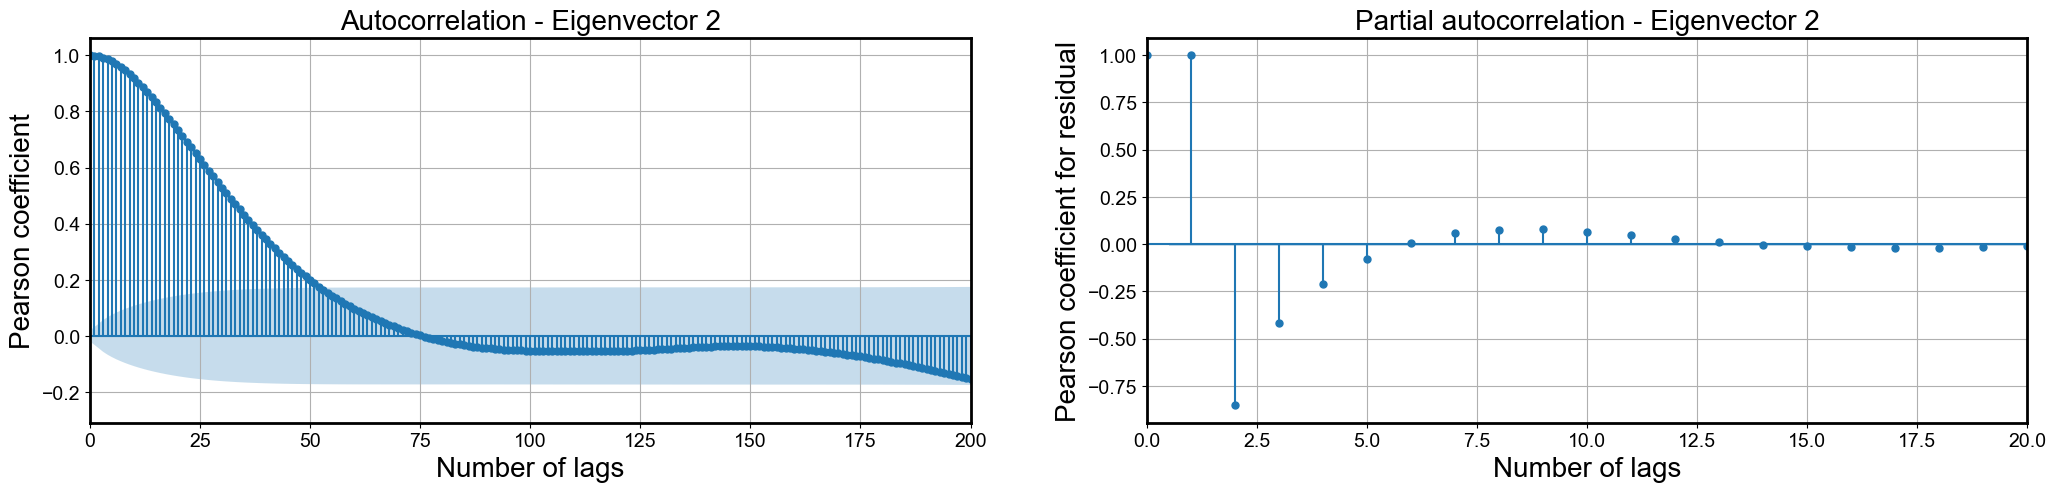

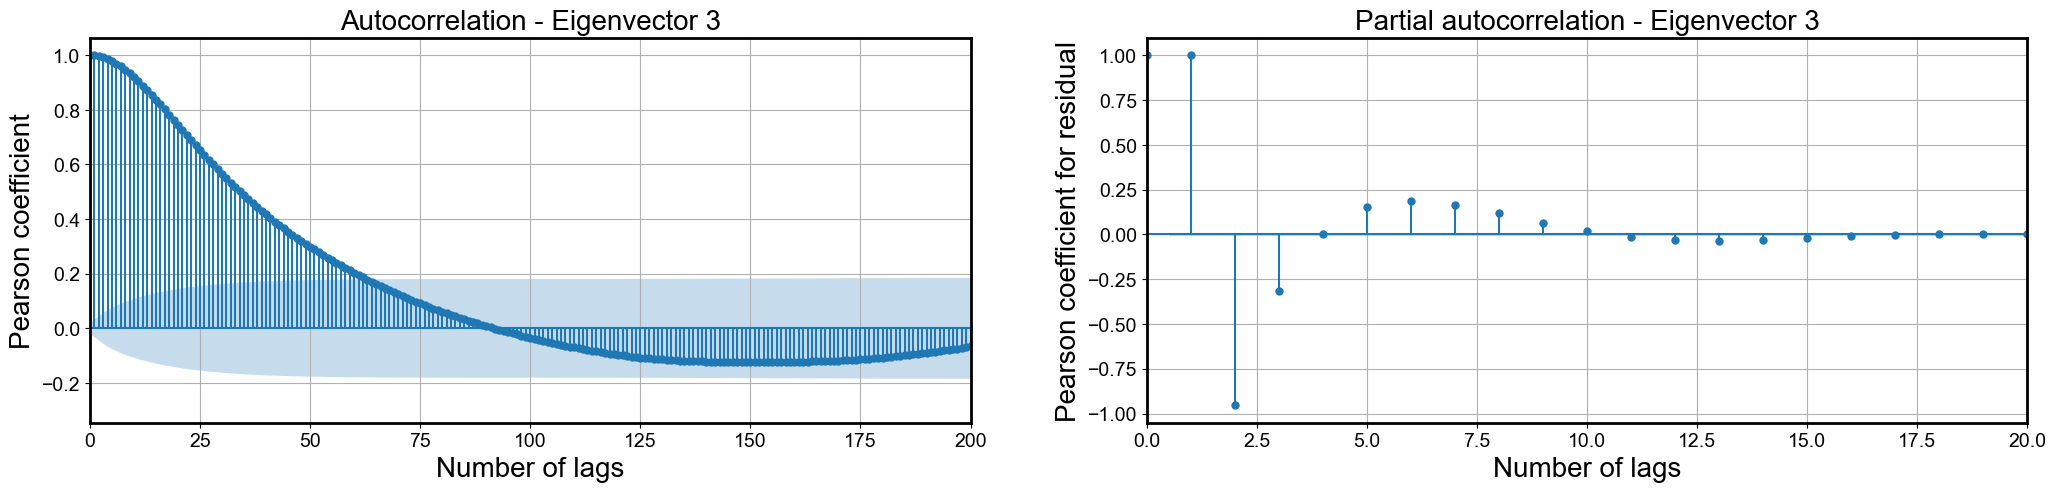

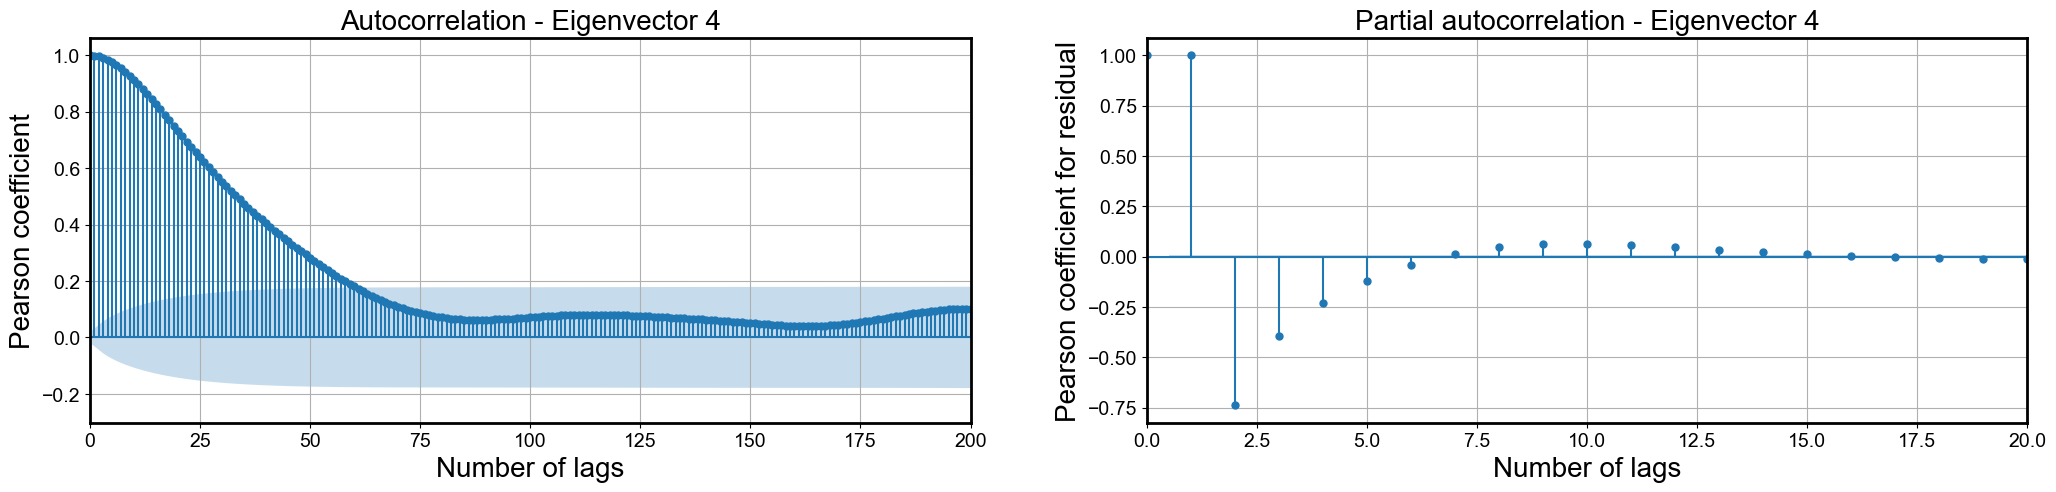

In [17]:
for i in tqdm(range(5)):
    plot_autocorrelation(df,i,zoom=True,acf_lim=200)

In [18]:
#from statsmodels.tsa.seasonal import seasonal_decompose
#from matplotlib import pyplot

#result = seasonal_decompose(series, model='additive')
#result.plot()
#pyplot.show()

From the autocorrelation plot, we see that our data is non stationary since it decays slowly.

From the partial autocorrelation plots, the most extreme lag that can be used a predictor would a lag between 1 and 6 based on the Pearson coefficient, which is a very small window (1.5 seconds). 

## Differencing time series

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]


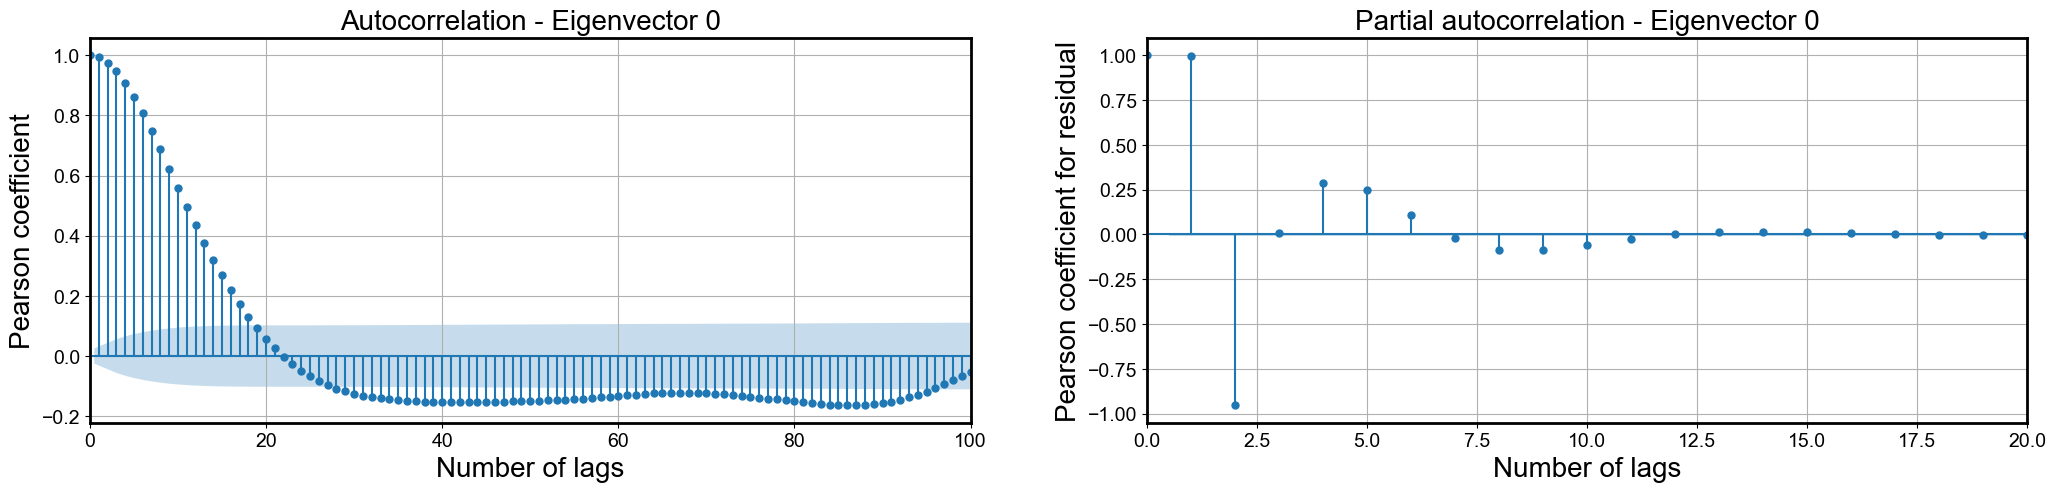

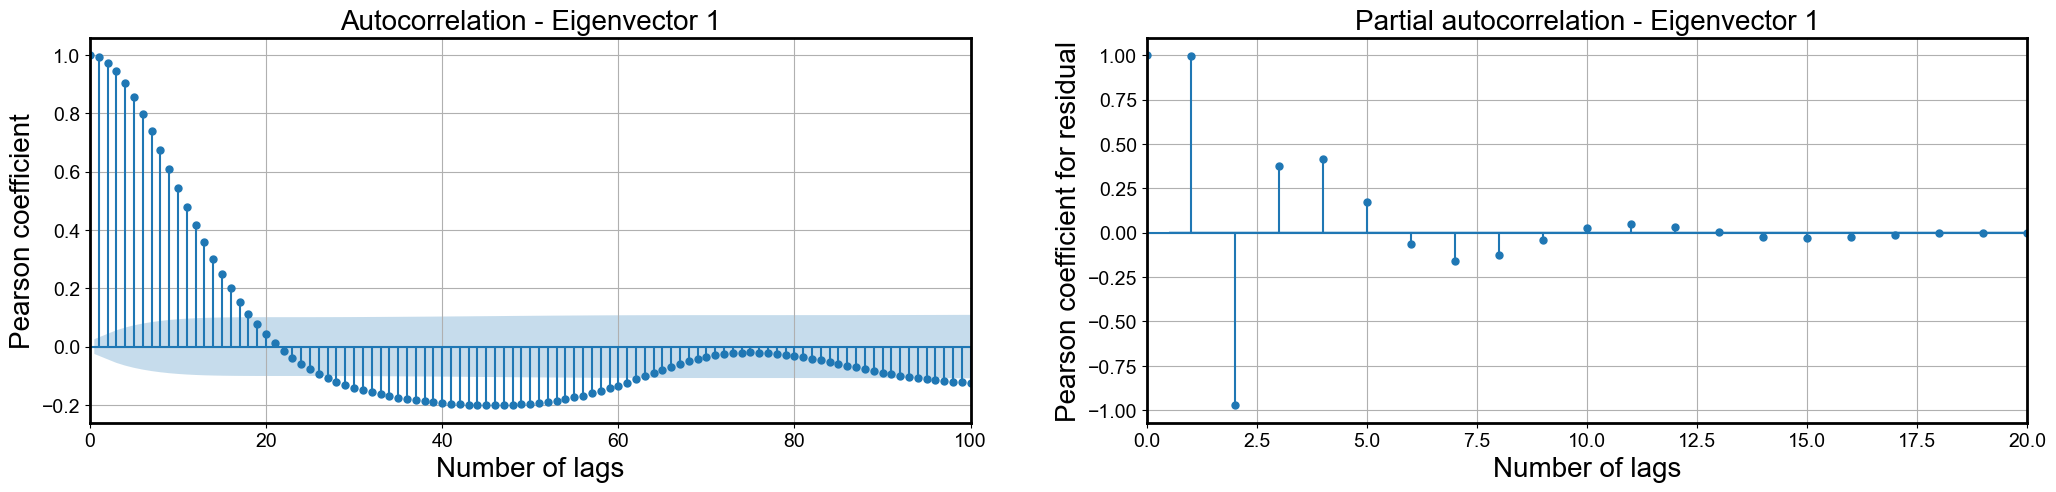

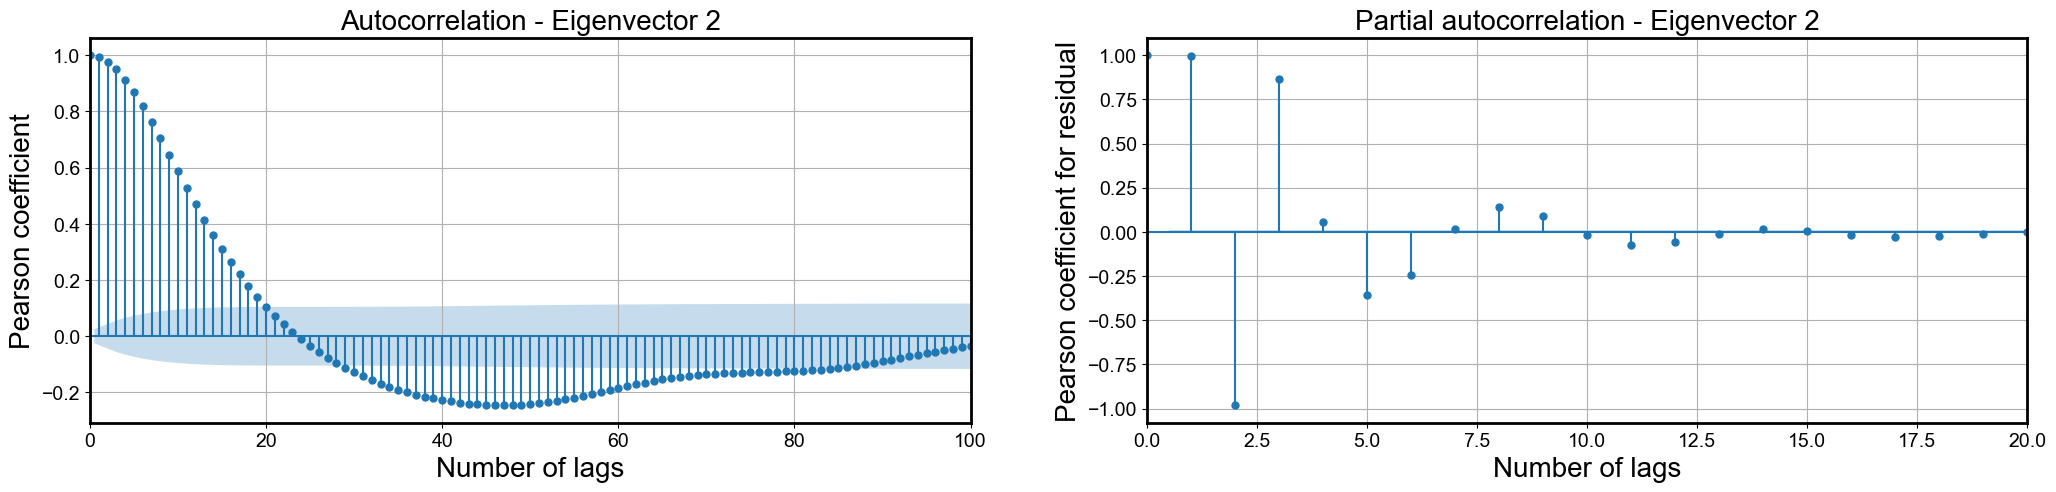

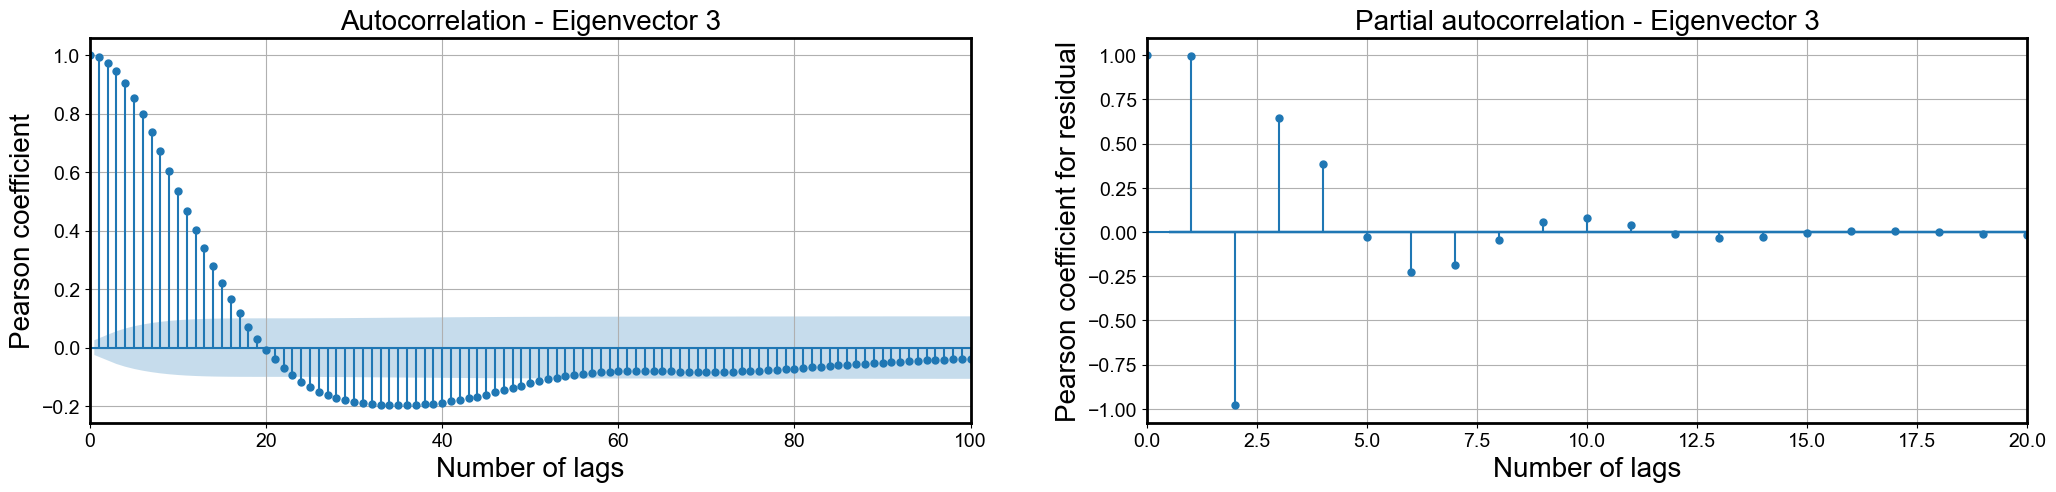

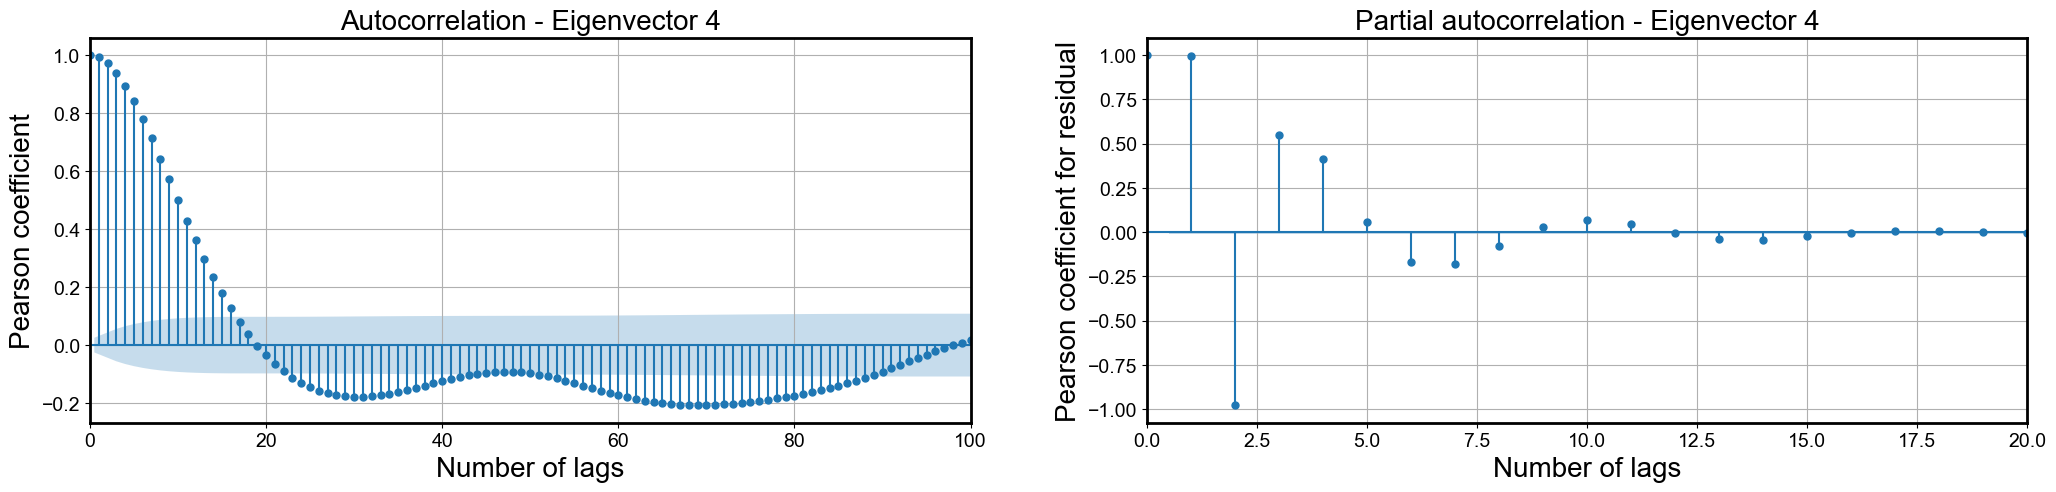

In [19]:
df_diff = df.diff(periods=1)
df_diff1 = df_diff.dropna()
df_diff1

for i in tqdm(np.arange(0,3,1)):
    plot_autocorrelation(df_diff1,i,zoom=True)

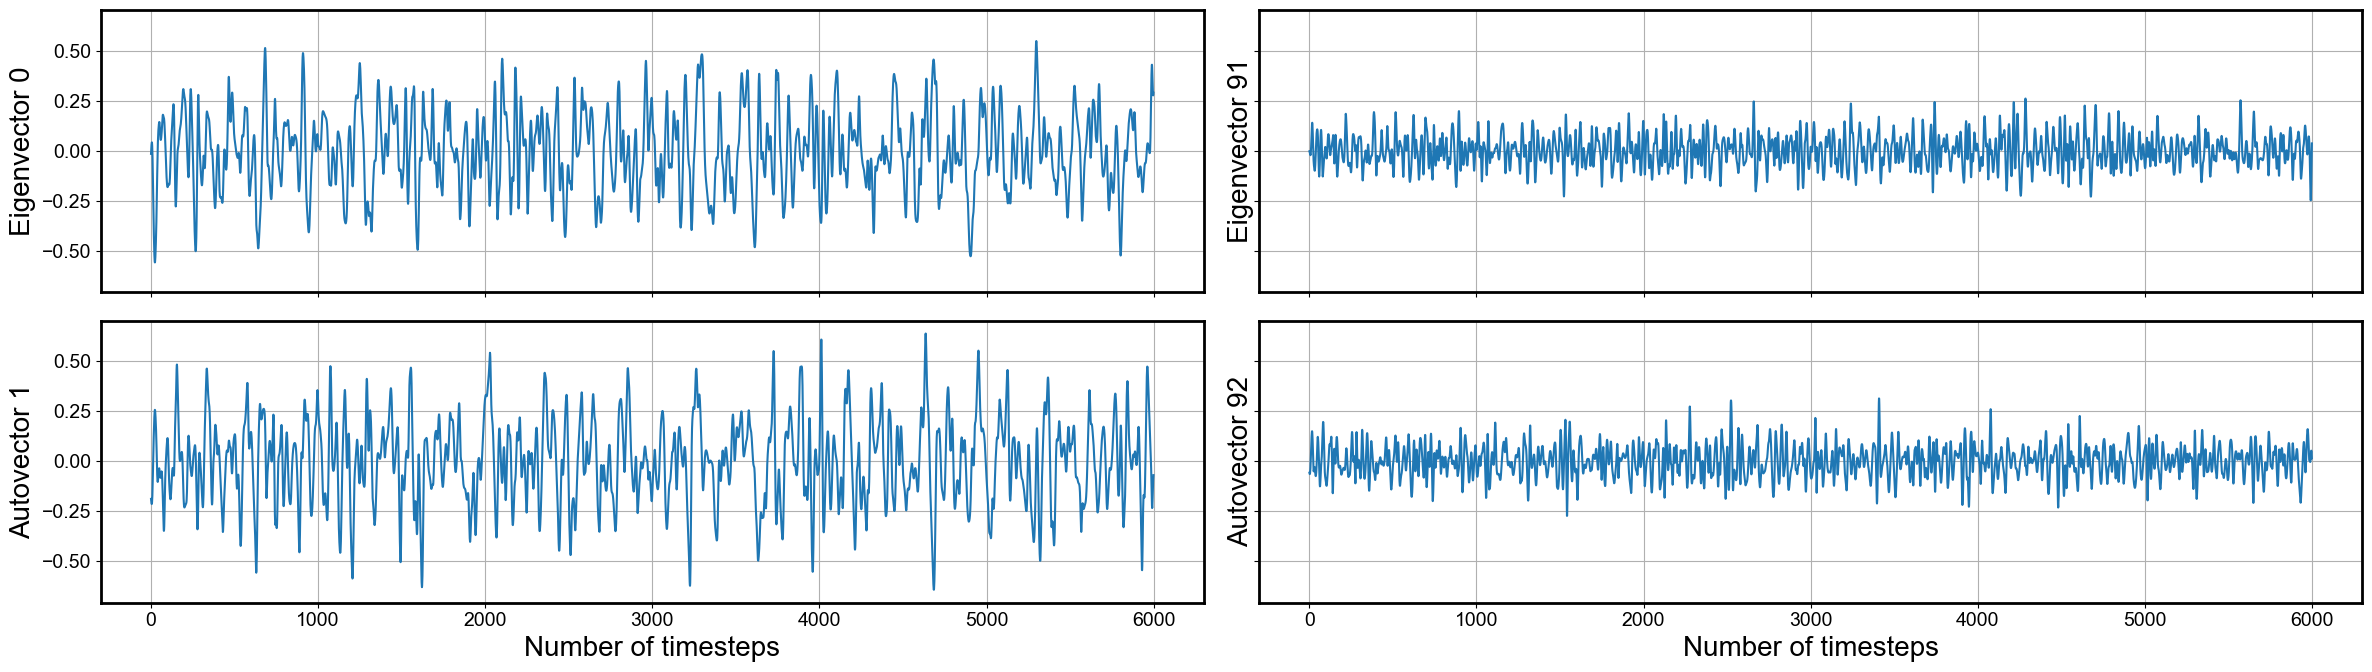

In [20]:
plot_samples(df_diff1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]


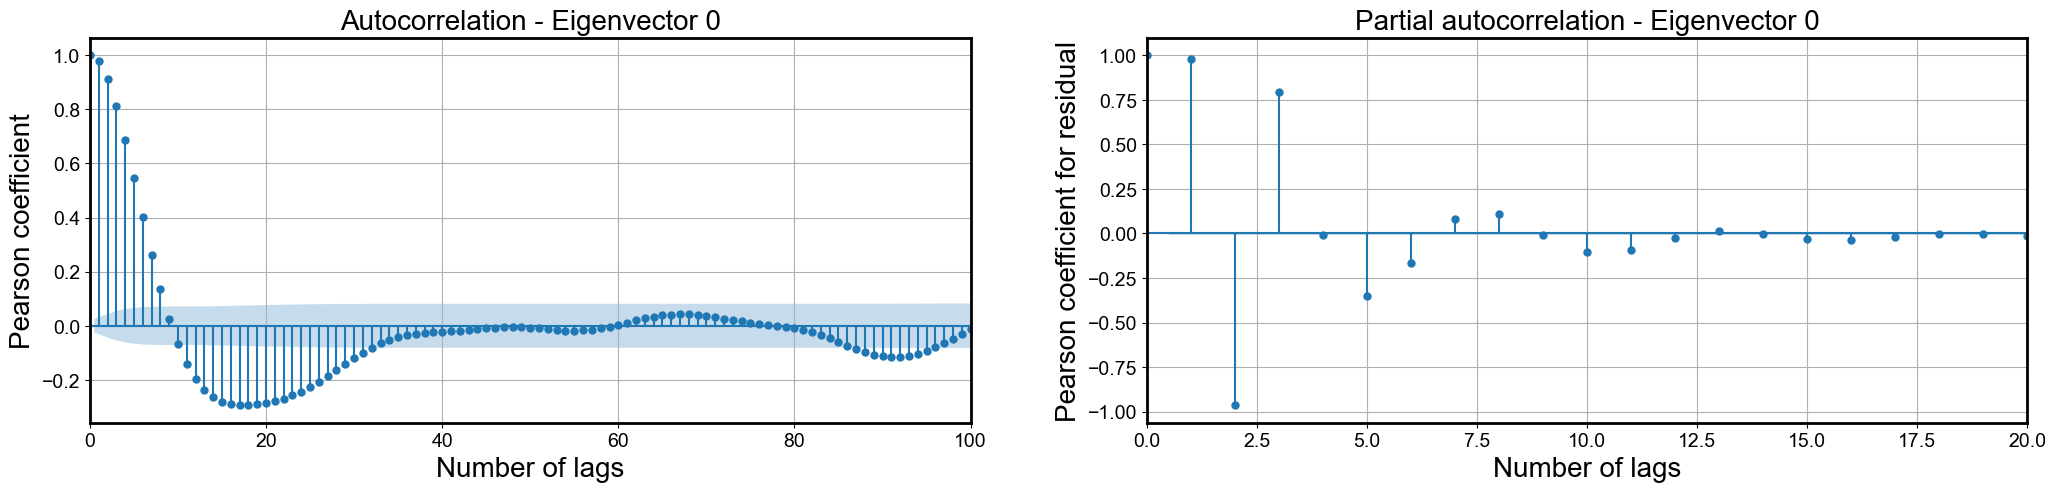

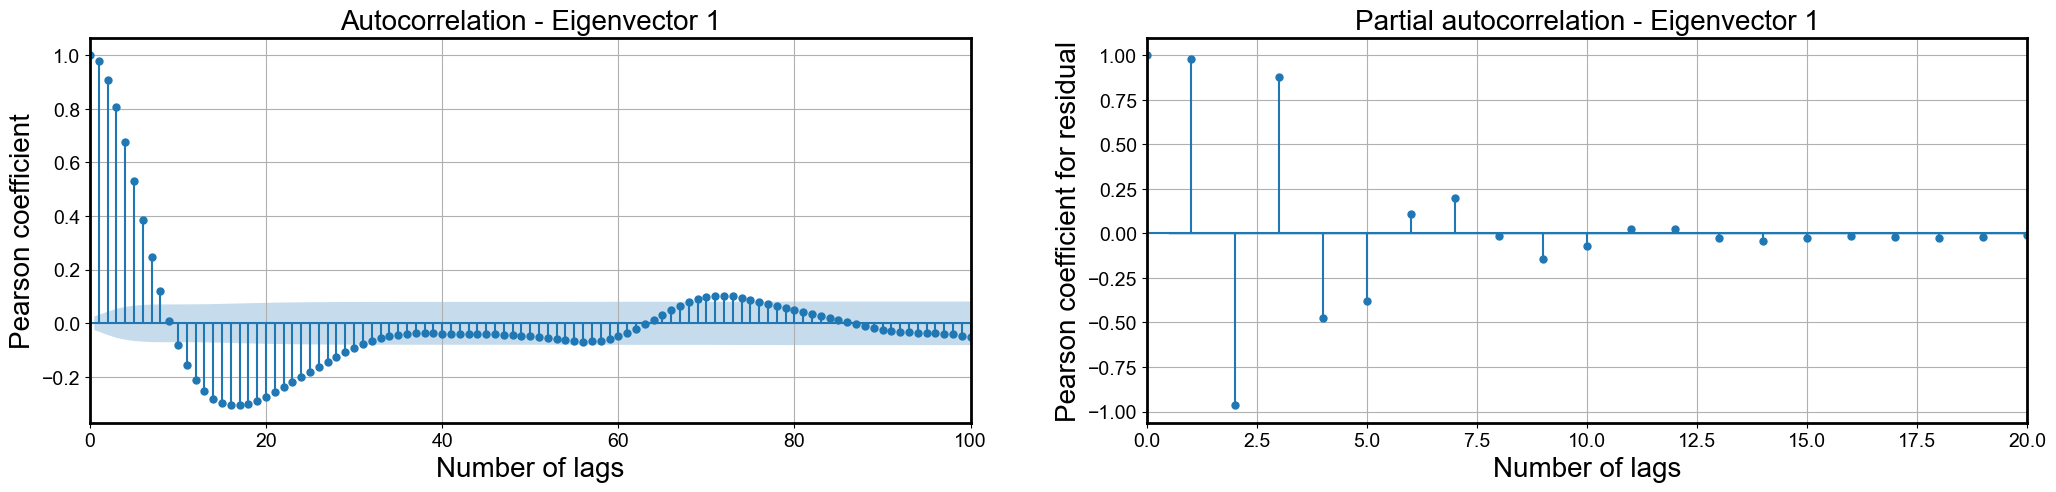

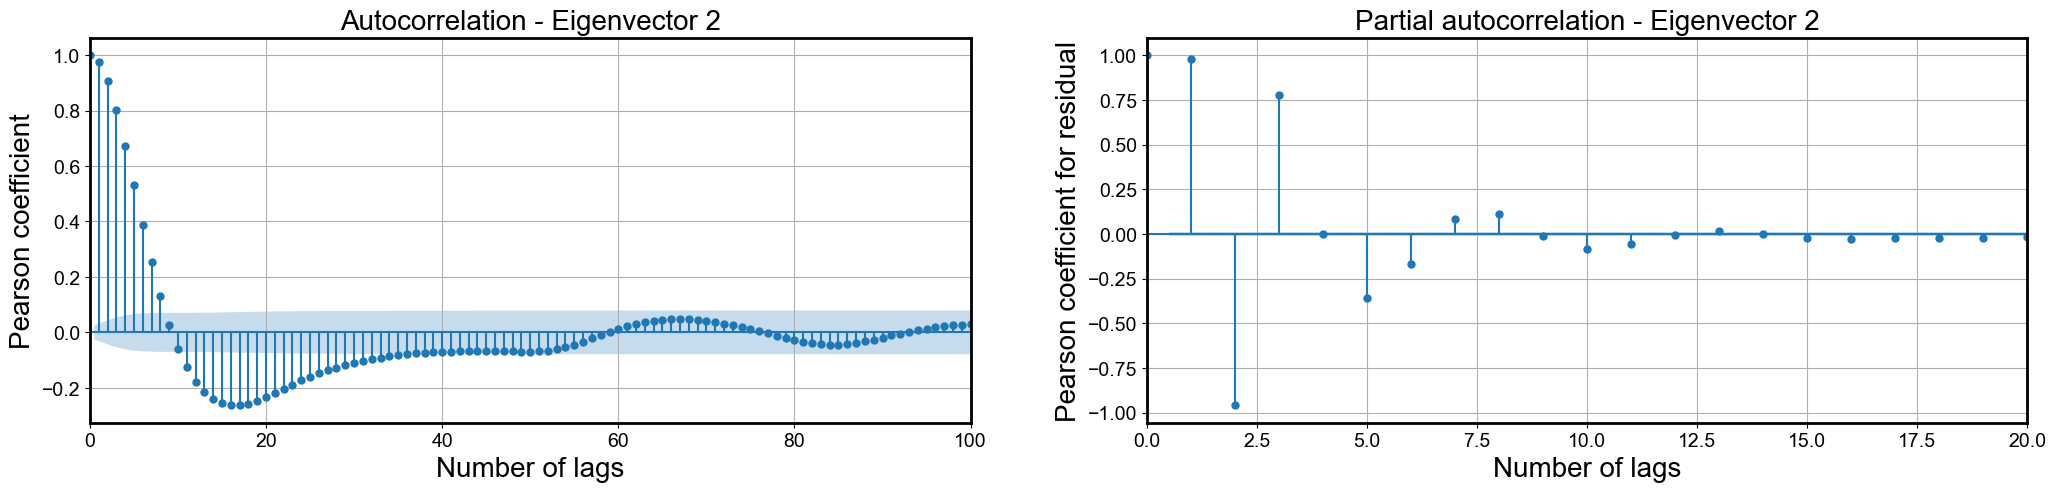

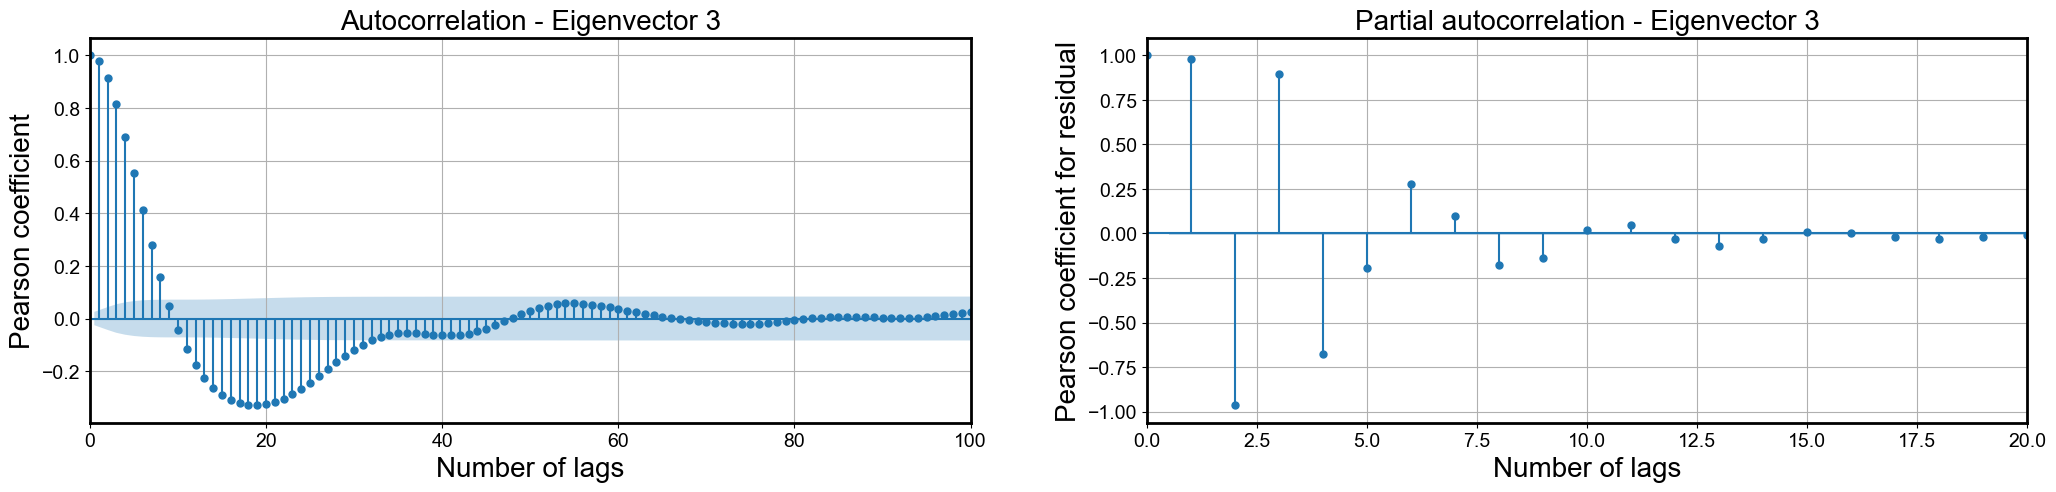

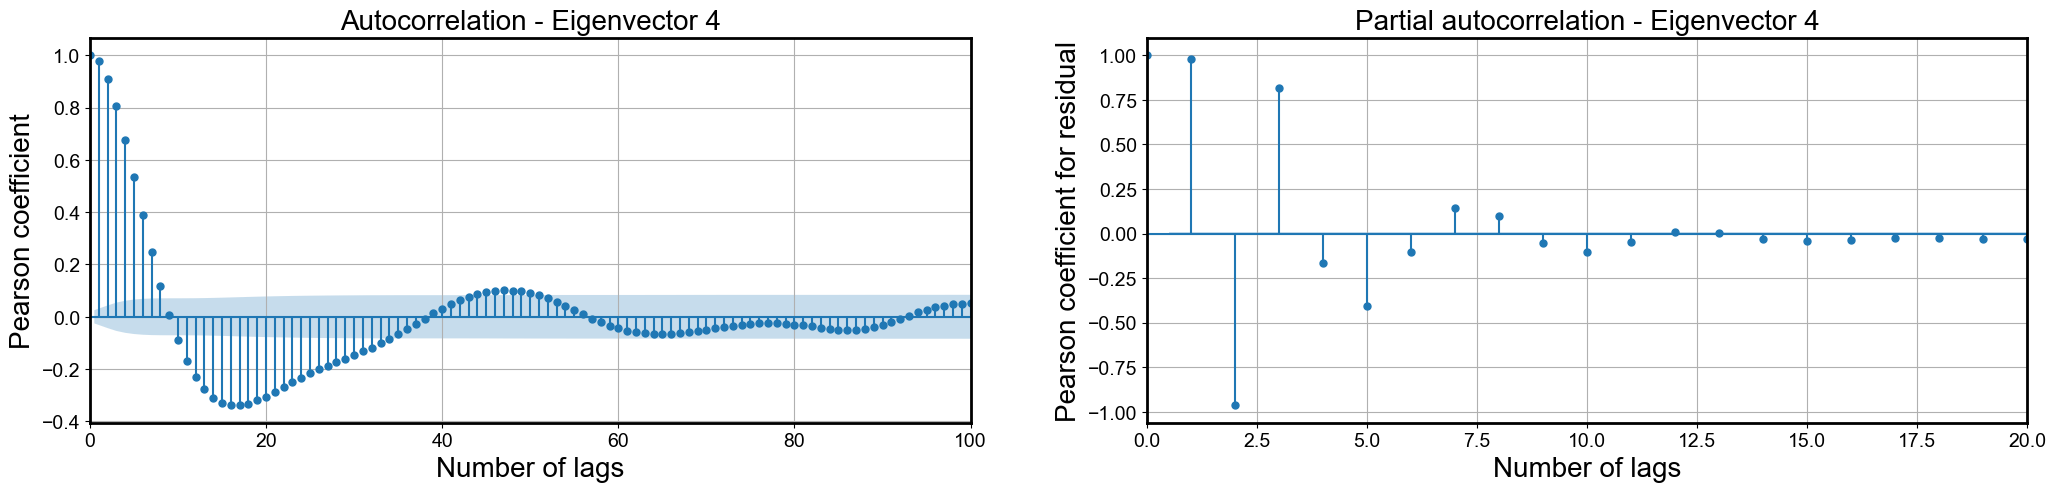

In [21]:
df_diff2= df_diff1.diff(periods=1)
df_diff2 = df_diff2.dropna()
df_diff2

for i in tqdm(np.arange(0,5,1)):
    plot_autocorrelation(df_diff2,i,zoom=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


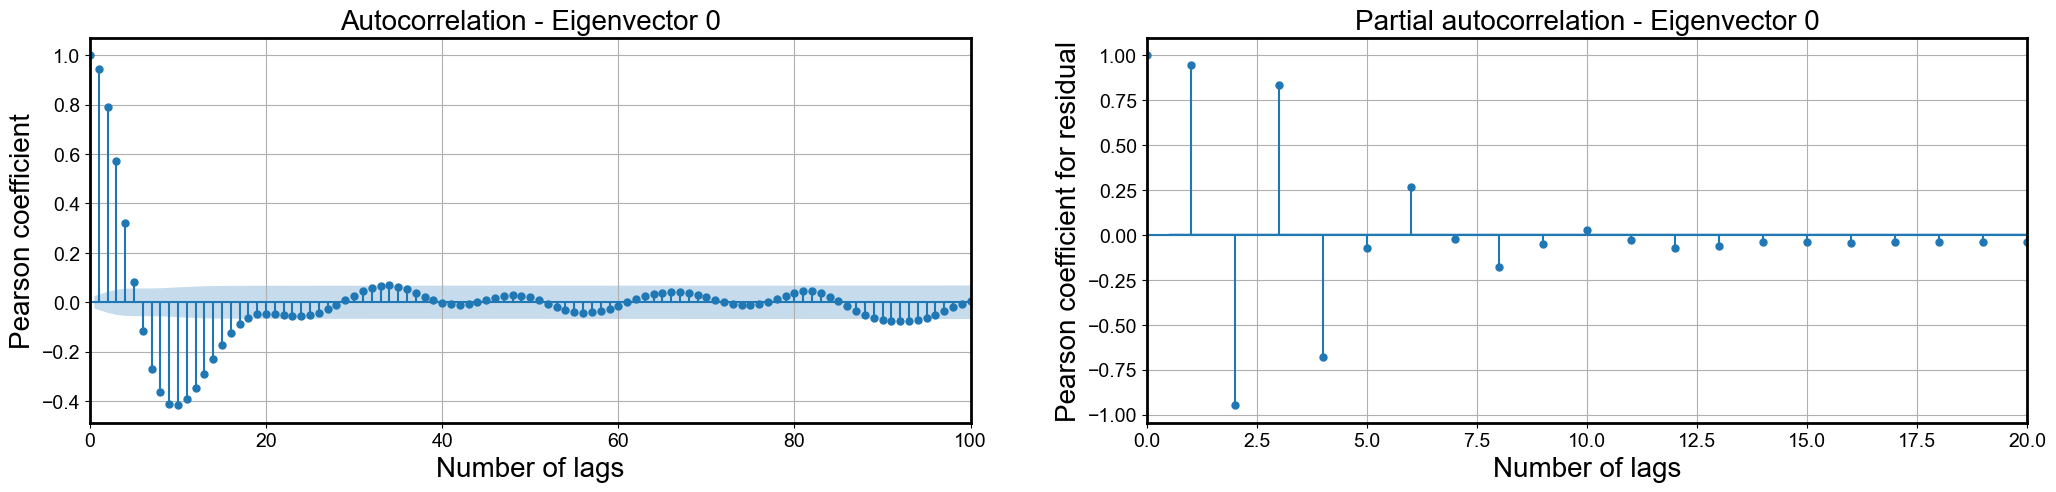

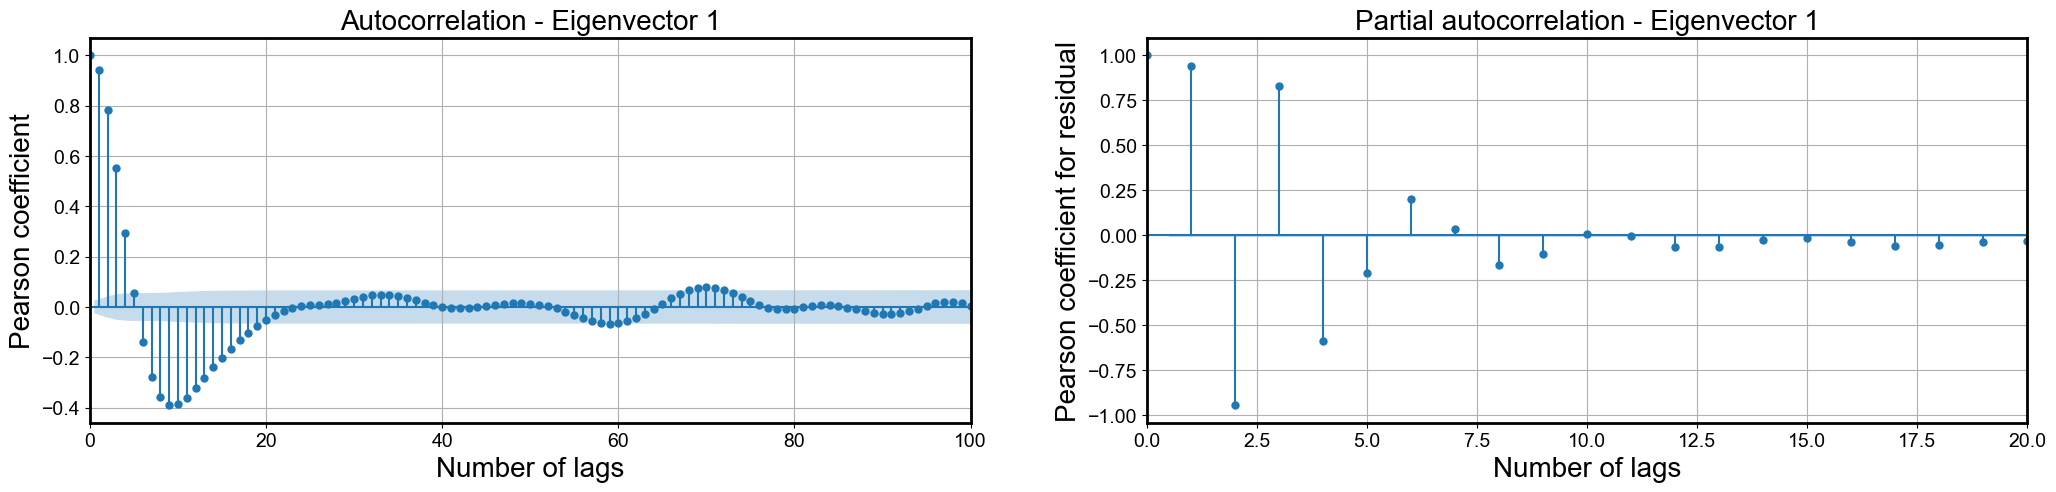

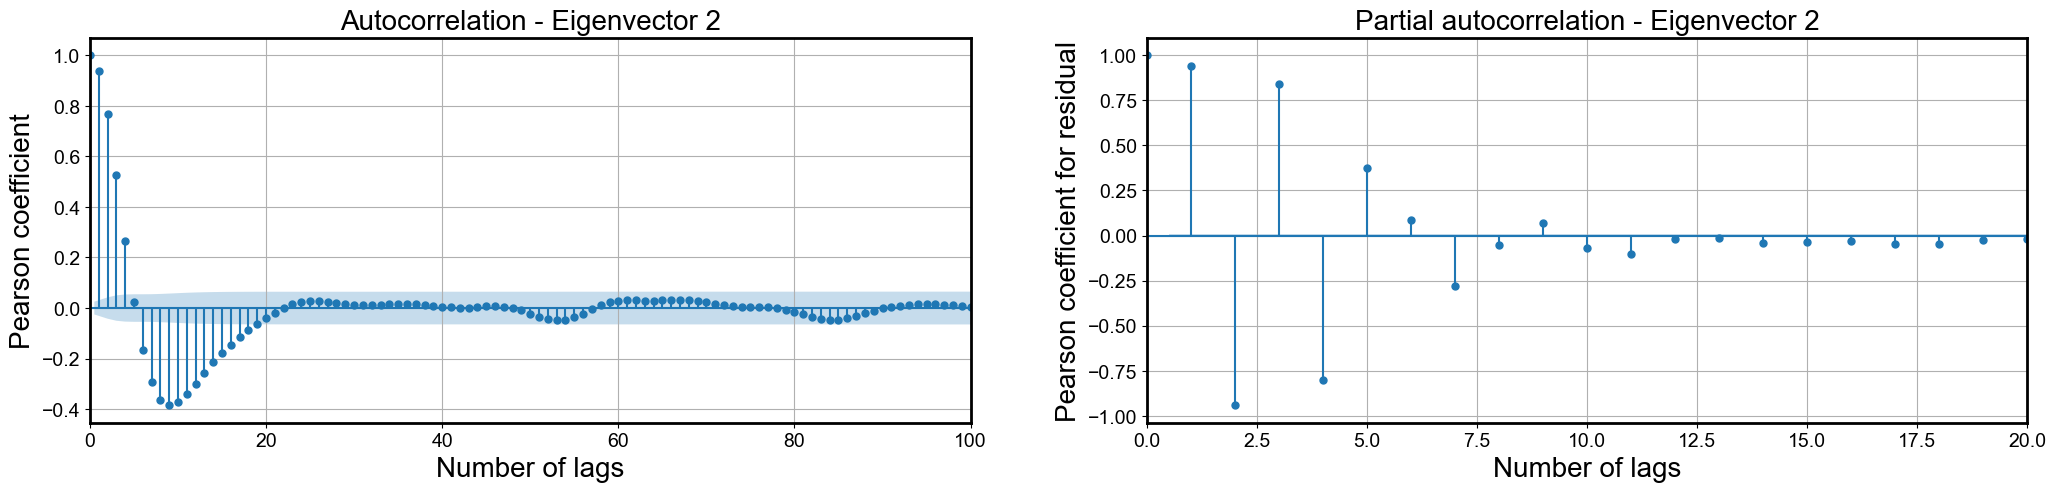

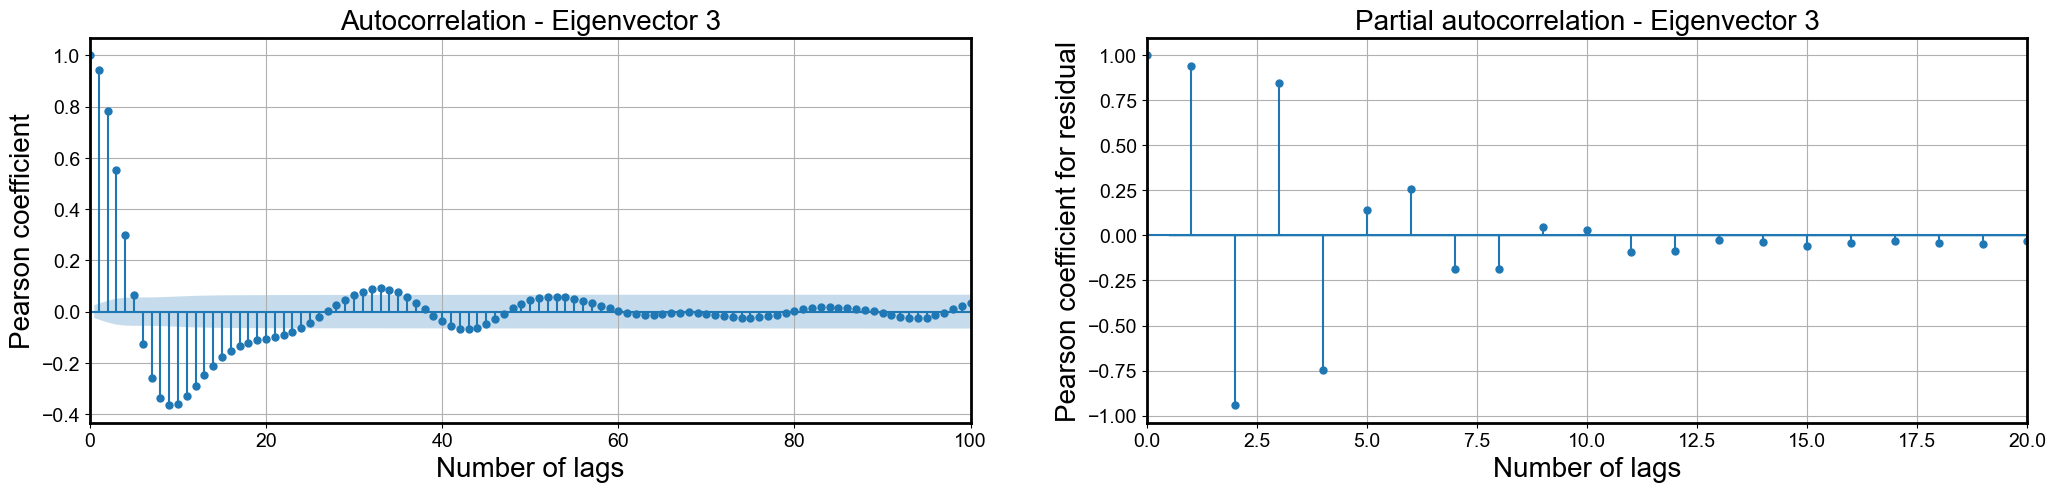

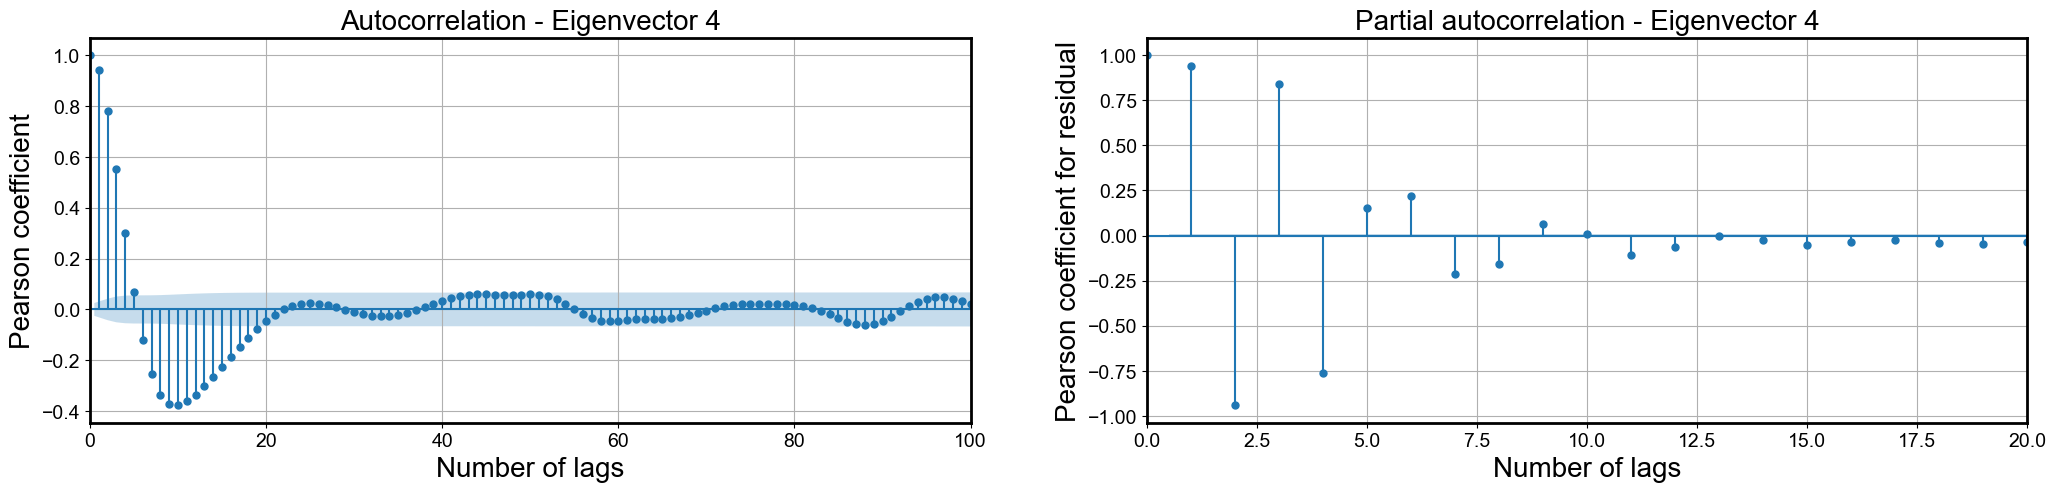

In [22]:
df_diff3= df_diff2.diff(periods=1)
df_diff3 = df_diff3.dropna()
df_diff3

for i in tqdm(np.arange(0,5,1)):
    plot_autocorrelation(df_diff3,i,zoom=True)

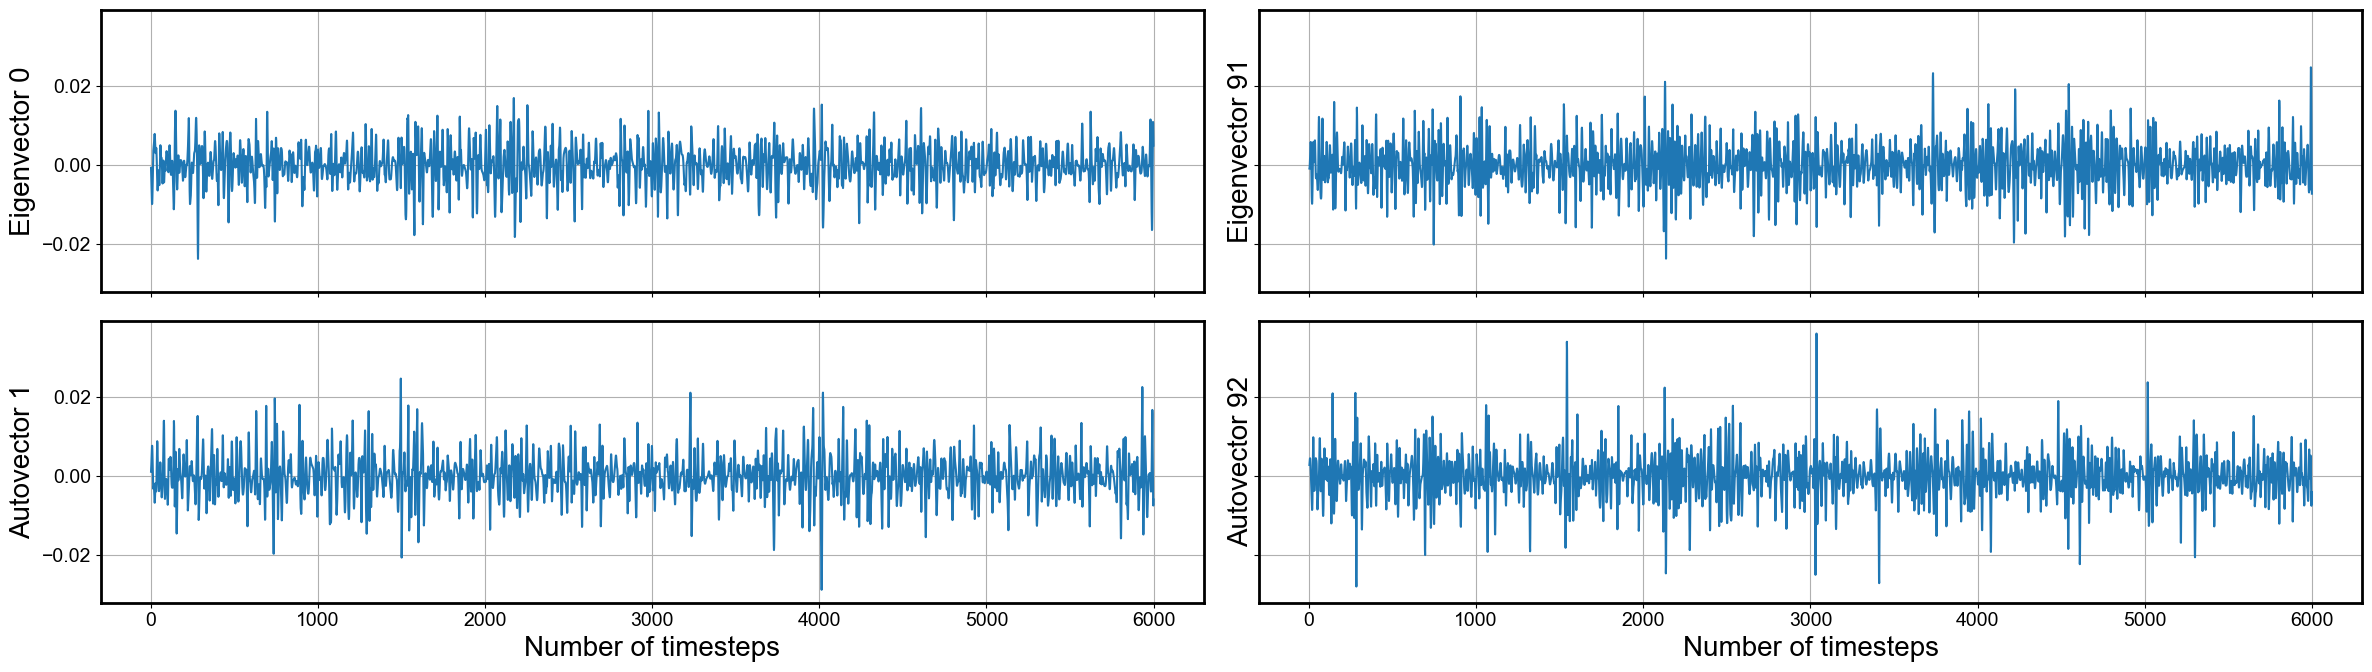

In [23]:
plot_samples(df_diff3)

Differencing the time series does not make it stationary

# Visualizing stationarity

We can break our time series into multiple segments and analyze the summary statistics of each against the time series or another partition to see if our time series data is changing through time.

We divide the time series into 4 segments

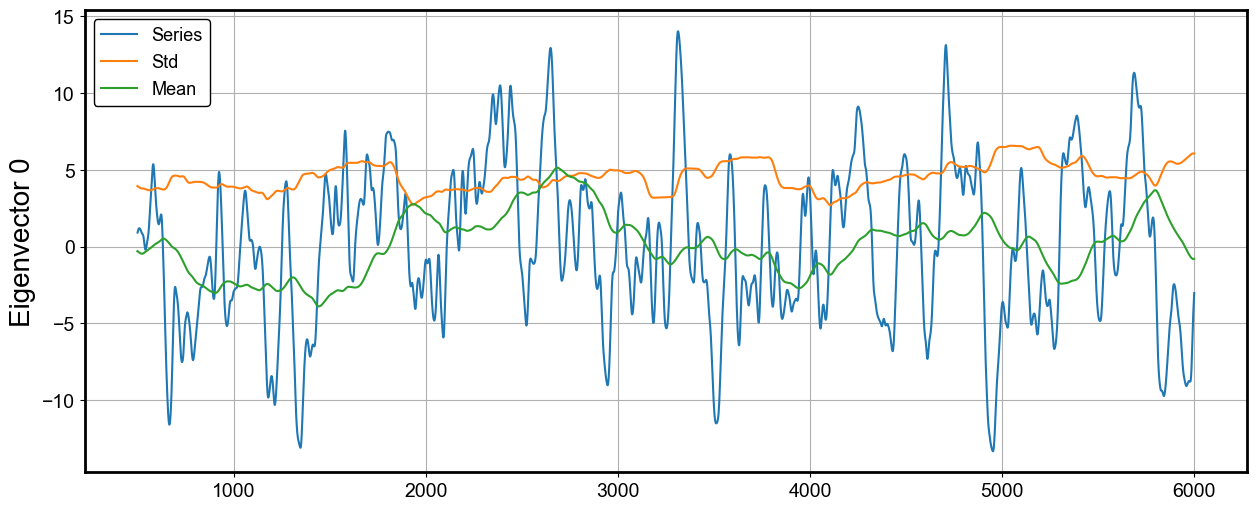

In [30]:
window=500
plt.plot(series[window:],label='Series')
plt.plot(series.rolling(window).std(),label='Std')
plt.plot(series.rolling(window).mean(),label='Mean')

plt.ylabel('Eigenvector 0')
plt.legend()

#plt.axvline(1500,color='red')
#plt.axvline(3000,color='red')
#plt.axvline(4500,color='red')
#plt.axvline(6000,color='red')

Depending on the selected window, the time series will highlight non stationary behaviour

In [25]:
def get_quads(df):
    quadlen = int(len(df) * 0.25)
    ss = df[:quadlen].describe()
    ss[1] = df[quadlen:quadlen*2].describe()
    ss[2] = df[quadlen*2:quadlen*3].describe()
    ss[3] = df[quadlen*3:].describe()
    return ss

In [26]:
get_quads(series)

0            1            2            3
count  1500.000000  1500.000000  1500.000000  1500.000000
mean     -1.946009     2.211675    -0.269072     0.003406
std       4.460381     4.364494     4.635460     5.789410
min     -13.086754    -9.022334   -11.503837   -13.318577
25%      -4.933807    -1.102797    -3.683147    -4.572181
50%      -1.686104     2.512532    -1.228146     0.272441
75%       1.189819     5.212952     3.045679     4.616305
max       8.586689    12.927298    14.015575    13.117358

In [27]:
get_quads(pd.DataFrame(df[df.columns[69]]))

69            1            2            3
count  1500.000000  1500.000000  1500.000000  1500.000000
mean      0.094061     0.008471    -0.080706    -0.021826
std       1.068366     1.135873     1.040475     1.022063
min      -2.800921    -3.167810    -2.653011    -3.125892
25%      -0.623814    -0.702416    -0.843666    -0.723178
50%       0.058061     0.115975    -0.032200    -0.066431
75%       0.827905     0.797772     0.727995     0.614996
max       2.729194     3.033788     2.050037     3.262360

## Statistical tests - Dickey Fuller

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

If it is, then p > 0.05, and the process is not stationary.
Otherwise, p < 0.05, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [32]:
# Augmented Dickey-Fuller Test
#from statsmodels.tsa.stattools import adfuller 

#def ADF_test(timeseries, dataDesc):
#    print(' > Is {} stationary?'.format(dataDesc))
#    dftest = adfuller(timeseries.dropna(), autolag='t-stat')
#    print('Test statistic = {:.3f}'.format(dftest[0]))
#    print('P-value = {:.3f}'.format(dftest[1]))
#    print('Lags used = {:.3f}'.format(dftest[2]))
#    print('Critical values :')
#    for k, v in dftest[4].items():
#        print('\t{}: {} - The data is{} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

#for i in range(15):
#    ADF_test(df[df.columns[i]],'Autovector ' + str(i))
#    print('')

# Summary

We are dealing with time series that are:

- Non stationary
- Anti-Persistent (fluctuates a lot around the mean)
- Not random
- No seasonality
- The 6 lag values contain useful information